In [1]:
# Import the required modules
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Pre-Processing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read the CSV file from the Resources folder into a Pandas DataFrame
df_full = pd.read_csv('used_clean.csv')

# Review the DataFrame
df_full.head()

,price,miles,year,make,model,trim,body_type,vehicle_type,drivetrain,transmission,fuel_type,engine_size,engine_block,city,state,zip
0,24411.0,69051,2017,Chevrolet,Express Cargo,Work Van,Cargo Van,Truck,RWD,Automatic,E85 / Unleaded,4.8,V,Manchester,MD,21102.0
1,48500.0,47916,2018,Ford,F-150,Lariat,Pickup,Truck,4WD,Automatic,Unleaded,3.5,V,Harrisburg,PA,17111.0
2,12981.0,92889,2017,Ford,Focus,SE,Sedan,Car,FWD,Automatic,E85 / Unleaded,2.0,I,Greenwood,IN,46143.0
3,18650.0,41815,2019,Hyundai,Veloster,Ultimate,Coupe,Car,FWD,Manual,Unleaded,1.6,I,Plainfield,IN,46168.0
4,28776.0,103774,2017,Ford,F-150,XLT,Pickup,Truck,4WD,Automatic,Unleaded,2.7,V,Boaz,AL,35957.0


In [3]:
df_limited = df_full.iloc[:10000]
df_limited.shape

(10000, 16)

In [4]:
col = ['price', 'miles', 'year', 'make', 'model', 'body_type',
       'vehicle_type', 'drivetrain', 'transmission', 'fuel_type',
       'engine_size', 'engine_block', 'state']

df = df_limited[col].copy()

In [5]:
df["engine_size"] = df["engine_size"].apply(lambda x: 0 if x == 'E' else x)
df.head()

,price,miles,year,make,model,body_type,vehicle_type,drivetrain,transmission,fuel_type,engine_size,engine_block,state
0,24411.0,69051,2017,Chevrolet,Express Cargo,Cargo Van,Truck,RWD,Automatic,E85 / Unleaded,4.8,V,MD
1,48500.0,47916,2018,Ford,F-150,Pickup,Truck,4WD,Automatic,Unleaded,3.5,V,PA
2,12981.0,92889,2017,Ford,Focus,Sedan,Car,FWD,Automatic,E85 / Unleaded,2.0,I,IN
3,18650.0,41815,2019,Hyundai,Veloster,Coupe,Car,FWD,Manual,Unleaded,1.6,I,IN
4,28776.0,103774,2017,Ford,F-150,Pickup,Truck,4WD,Automatic,Unleaded,2.7,V,AL


In [6]:
df.engine_size = df.engine_size.astype(float)

In [7]:
def label_engine_size(engine):
    if 0.1 <= engine < 2:
        return 1
    elif 2 <= engine < 3:
        return 2
    elif 3 <= engine < 4:
        return 3
    elif 4 <= engine < 5:
        return 4
    elif 5 <= engine < 6:
        return 5
    elif 6 <= engine < 7:
        return 6
    elif 7 <= engine < 8:
        return 7
    else:
        return 0

# Apply the custom function to the 'fuel_type' column
df['engine_size'] = df['engine_size'].apply(label_engine_size)

# Show the modified DataFrame
df.head(10)

,price,miles,year,make,model,body_type,vehicle_type,drivetrain,transmission,fuel_type,engine_size,engine_block,state
0,24411.0,69051,2017,Chevrolet,Express Cargo,Cargo Van,Truck,RWD,Automatic,E85 / Unleaded,4,V,MD
1,48500.0,47916,2018,Ford,F-150,Pickup,Truck,4WD,Automatic,Unleaded,3,V,PA
2,12981.0,92889,2017,Ford,Focus,Sedan,Car,FWD,Automatic,E85 / Unleaded,2,I,IN
3,18650.0,41815,2019,Hyundai,Veloster,Coupe,Car,FWD,Manual,Unleaded,1,I,IN
4,28776.0,103774,2017,Ford,F-150,Pickup,Truck,4WD,Automatic,Unleaded,2,V,AL
5,45800.0,27211,2017,INFINITI,QX80,SUV,Truck,RWD,Automatic,Premium Unleaded,5,V,TX
6,65464.0,6129,2020,GMC,Sierra 1500 Denali,Pickup,Truck,4WD,Automatic,Unleaded,6,V,MO
7,16800.0,10006,2018,Chevrolet,Trax,SUV,Truck,FWD,Automatic,Unleaded,1,I,MI
8,25590.0,16051,2020,Toyota,Prius Prime,Hatchback,Car,FWD,Automatic,Electric / Unleaded,1,I,AZ
9,47885.0,52248,2017,Ford,F-150,Pickup,Truck,4WD,Automatic,Unleaded,3,V,GA


In [8]:
df.model.value_counts()

model
F-150                     346
Silverado 1500            277
Ram 1500 Pickup           228
Equinox                   206
Escape                    177
                         ... 
LC                          1
Sprinter Passenger Van      1
F-PACE                      1
QX70                        1
MX-5 Miata RF               1
Name: count, Length: 416, dtype: int64

In [11]:
cutoff = 200
application_types_to_replace = df.model.value_counts()[df.model.value_counts() < cutoff].index.tolist()

# Replace in dataframe
for app in application_types_to_replace:
    df['model'] = df['model'].replace(app,"Other")

# Check to make sure replacement was successful
df['model'].value_counts()

model
Other              8943
F-150               346
Silverado 1500      277
Ram 1500 Pickup     228
Equinox             206
Name: count, dtype: int64

In [12]:
def label_fuel_type(fuel):
    fuel = fuel.lower()  # Convert to lowercase for consistent matching
    if 'diesel' in fuel:
        return 'Diesel'
    elif 'electric' in fuel and '/' in fuel:
        return 'Hybrid'
    elif fuel == 'electric':
        return 'Electric'
    else:
        return 'Gas'

# Apply the custom function to the 'fuel_type' column
df['fuel_type'] = df['fuel_type'].apply(label_fuel_type)

# Show the modified DataFrame
df.head(10)

,price,miles,year,make,model,body_type,vehicle_type,drivetrain,transmission,fuel_type,engine_size,engine_block,state
0,24411.0,69051,2017,Chevrolet,Other,Cargo Van,Truck,RWD,Automatic,Gas,4,V,MD
1,48500.0,47916,2018,Ford,F-150,Pickup,Truck,4WD,Automatic,Gas,3,V,PA
2,12981.0,92889,2017,Ford,Other,Sedan,Car,FWD,Automatic,Gas,2,I,IN
3,18650.0,41815,2019,Hyundai,Other,Coupe,Car,FWD,Manual,Gas,1,I,IN
4,28776.0,103774,2017,Ford,F-150,Pickup,Truck,4WD,Automatic,Gas,2,V,AL
5,45800.0,27211,2017,INFINITI,Other,SUV,Truck,RWD,Automatic,Gas,5,V,TX
6,65464.0,6129,2020,GMC,Other,Pickup,Truck,4WD,Automatic,Gas,6,V,MO
7,16800.0,10006,2018,Chevrolet,Other,SUV,Truck,FWD,Automatic,Gas,1,I,MI
8,25590.0,16051,2020,Toyota,Other,Hatchback,Car,FWD,Automatic,Hybrid,1,I,AZ
9,47885.0,52248,2017,Ford,F-150,Pickup,Truck,4WD,Automatic,Gas,3,V,GA


In [13]:
def label_body_type(body):
    if 'Car Van'  in body or 'Combi' in body:
        return 'Cargo Van'
    elif 'Targa' in body or 'Roadster' in body:
        return 'Coupe'
    elif 'Cutaway' in body or 'Chassis Cab' in body:
        return 'Pickup'
    elif 'Targa' in body:
        return 'Roadster'
    elif 'Mini Mpv' in body:
        return 'Hatchback'
    elif 'Passenger Van' in body:
        return 'Minivan'
    else:
        return body

# Apply the custom function to the 'fuel_type' column
df['body_type'] = df['body_type'].apply(label_body_type)

# Show the modified DataFrame
df.head(10)

,price,miles,year,make,model,body_type,vehicle_type,drivetrain,transmission,fuel_type,engine_size,engine_block,state
0,24411.0,69051,2017,Chevrolet,Other,Cargo Van,Truck,RWD,Automatic,Gas,4,V,MD
1,48500.0,47916,2018,Ford,F-150,Pickup,Truck,4WD,Automatic,Gas,3,V,PA
2,12981.0,92889,2017,Ford,Other,Sedan,Car,FWD,Automatic,Gas,2,I,IN
3,18650.0,41815,2019,Hyundai,Other,Coupe,Car,FWD,Manual,Gas,1,I,IN
4,28776.0,103774,2017,Ford,F-150,Pickup,Truck,4WD,Automatic,Gas,2,V,AL
5,45800.0,27211,2017,INFINITI,Other,SUV,Truck,RWD,Automatic,Gas,5,V,TX
6,65464.0,6129,2020,GMC,Other,Pickup,Truck,4WD,Automatic,Gas,6,V,MO
7,16800.0,10006,2018,Chevrolet,Other,SUV,Truck,FWD,Automatic,Gas,1,I,MI
8,25590.0,16051,2020,Toyota,Other,Hatchback,Car,FWD,Automatic,Hybrid,1,I,AZ
9,47885.0,52248,2017,Ford,F-150,Pickup,Truck,4WD,Automatic,Gas,3,V,GA


In [14]:
# Define Preprocessing Pipelines

# Define preprocessing for numeric features (Age, Fare, Family_Size) (note that for age, we just use the column median, not split by gender)
numeric_features = ['miles', 'year', 'engine_size'] # You can also do this in a loop, select the numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Define preprocessing for the binary features (Sex, Has_Cabin)
binary_features = ['vehicle_type', 'transmission']
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', missing_values=pd.NA)),
    ('label', OrdinalEncoder())])  # Label encode for binary feature

# Define preprocessing for categorical features (Pclass, Embarked) 
categorical_features = ['make', 'model', 'body_type', 'drivetrain', 'fuel_type', 'engine_block', 'state']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', missing_values=pd.NA)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing for numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('binary', binary_transformer, binary_features),
        ('cat', categorical_transformer, categorical_features)])

In [15]:
# Step 1: Get the data (NOTE: this is the original dataframe, not the one used for the correlations)
X = df.drop(columns=["price"])
y = df.price

y = np.log(y)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1) # stratify=True maintains target class percentages
print(X_train.shape, X_test.shape)

(7500, 12) (2500, 12)


In [16]:
# Function for Regression
def doRegression(model, X_train, X_test, y_train, y_test):
    # Step 3: Fit the model
    model.fit(X_train, y_train)
    
    # Step 4: Evaluate the model
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    # Generate metrics TRAIN
    train_r2 = r2_score(y_train, train_preds)
    train_mse = mean_squared_error(y_train, train_preds)
    train_mae = mean_absolute_error(y_train, train_preds)
    train_rmse = np.sqrt(train_mse)
    
    train_results = f"""TRAIN METRICS
    R2: {train_r2}
    MSE: {train_mse}
    RMSE: {train_rmse}
    MAE: {train_mae}
    """
    
    print(train_results)

    # Generate metrics TEST
    test_r2 = r2_score(y_test, test_preds)
    test_mse = mean_squared_error(y_test, test_preds)
    test_mae = mean_absolute_error(y_test, test_preds)
    test_rmse = np.sqrt(test_mse)
    
    test_results = f"""TEST METRICS
    R2: {test_r2}
    MSE: {test_mse}
    RMSE: {test_rmse}
    MAE: {test_mae}
    """
    
    print(test_results)

    # VISUALIZE TEST RESULTS
    # Predicted vs Actual Plot
    plt.scatter(y_test, test_preds)
    plt.plot(y_test, y_test)
    plt.title("Predicted vs Actual Plot")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.show()

    # Residual Plot
    resids = test_preds - y_test
    plt.scatter(test_preds, resids)
    plt.hlines(0, min(test_preds), max(test_preds))
    plt.title("Residual Plot")
    plt.xlabel("Predictions")
    plt.ylabel("Residuals")
    plt.show()

TRAIN METRICS
    R2: 0.9783458660953658
    MSE: 0.004098968452392683
    RMSE: 0.06402318683408913
    MAE: 0.04693536785150354
    
TEST METRICS
    R2: 0.847376265918094
    MSE: 0.027775624896806256
    RMSE: 0.16666020789860506
    MAE: 0.12583512735916047
    


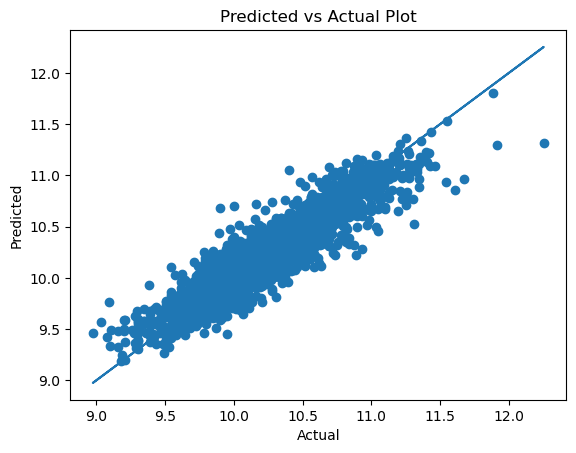

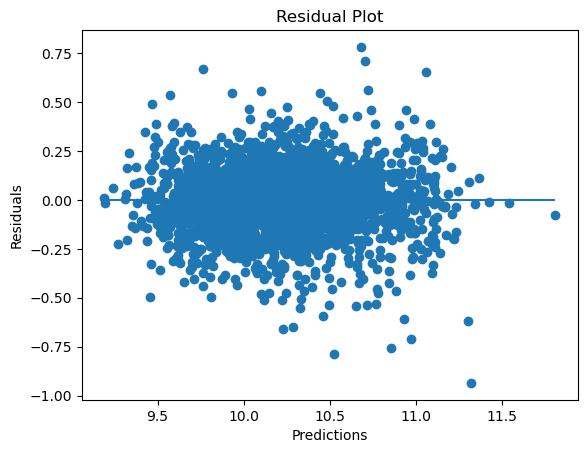

In [17]:
# Step 2: Init the Model
rf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestRegressor(random_state=42))
])

# Do Machine Learning
doRegression(rf, X_train, X_test, y_train, y_test)

In [18]:
# Create a pipeline with a scaler and a logistic regression model
rfr = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestRegressor(random_state=42))
])

# Perform 5-fold cross-validation with roc_auc scoring

cv = KFold(n_splits=5)  # For regression, KFold is used instead of StratifiedKFold
cv_scores = cross_val_score(rfr, X, y, cv=cv, scoring='neg_mean_squared_error')

# Output the results (MSE, so we negate the score to make it positive)
mse_scores = -cv_scores  # Cross_val_score returns negative values for MSE when using 'neg_mean_squared_error'
print(f"Cross-validation MSE scores: {mse_scores}")
print(f"Mean MSE: {np.mean(mse_scores):.3f}")
print(f"Mean RMSE: {np.sqrt(np.mean(mse_scores)):.3f}")  # Root Mean Squared Error (RMSE) is a more interpretable metric

Cross-validation MSE scores: [0.03011646 0.02859111 0.02788886 0.02747854 0.02870788]
Mean MSE: 0.029
Mean RMSE: 0.169


In [20]:
# Retrain the model on the ENTIRE dataset
gb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestRegressor(random_state=42))
])
gb.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['miles', 'year',
                                                   'engine_size']),
                                                 ('binary',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(missing_values=<NA>,
                                                                                 strategy='most_frequent')),
                                                                  ('label',
                                                                   OrdinalEncoder())]),
                                                  ['vehicle_type',
                                                   'transmission']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(missing_values=<NA>,
                                                                                 strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['make', 'model', 'body_type',
                                                   'drivetrain', 'fuel_type',
                                                   'engine_block',
                                                   'state'])])),
                ('classifier', RandomForestRegressor(random_state=42))])

In [21]:
# Save off my models
import pickle

# Model
pickle.dump(gb, open("bad_model.h5", 'wb'))